In [29]:
import pandas as pd
import numpy as np
# настройка пандаса
pd.set_option("max_columns", 500)
%pylab inline
import warnings
import seaborn as sns
warnings.simplefilter("ignore")
from sklearn.metrics import accuracy_score, f1_score
import missingno as msno
#import fancyimpute
from xgboost import XGBClassifier
import json
import json_lines

Populating the interactive namespace from numpy and matplotlib


In [30]:
train = pd.read_csv('input/train_features.csv', index_col='match_id_hash')
y_train_raw = pd.read_csv('input/train_targets.csv', index_col='match_id_hash')
test = pd.read_csv('input/test_features.csv', index_col='match_id_hash')
y_train = y_train_raw.radiant_win

In [31]:
test_index = test.index

In [32]:
train.head(2)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,d1_y,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_x,d2_y,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_x,d3_y,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,543,7,533,358,600,350.93784,2,116,122,0.0,0,0,1,0,0.0000,0,0,0,0,78,0,0,0,3,399,4,478,636,720,254.93774,2,124,126,0.000000,0,0,0,0,0.0000,0,0,0,0,14,0,1,0,0,304,0,130,700,700,242.93773,1,70,156,0.000000,0,0,1,0,0.0000,0,0,0,0,59,0,0,0,1,389,4,506,399,700,326.93780,2,170,86,0.0,0,0,0,0,0.0000,0,0,0,0,77,0,0,0,0,402,10,344,422,800,314.93780,2,120,100,0.000000,0,0,0,0,0.000,0,0,0,0,12,0,0,1,13,982,12,780,650,720,386.93787,3,82,170,0.000000,0,0,1,0,1.00,0,0,0,0,21,0,0,0,6,788,9,706,640,640,422.9379,3,174,90,0.00000,0,0,2,0,0.00,0,0,0,0,60,0,0,0,1,531,0,307,720,720,242.93773,2,180,84,0.299948,0,0,2,0,0.0,0,0,0,0,84,1,0,0,0,796,0,421,760,760,326

## Одинаковые id героев и в трейне и тесте

In [33]:
set(train[['{0}{1}_hero_id'.format(i,j) for i in ('r','d') for j in range(1,6)]].values.reshape(-1))==\
   set(test[['{0}{1}_hero_id'.format(i,j) for i in ('r','d') for j in range(1,6)]].values.reshape(-1))

True

## Максимальный id героя

In [34]:
max(train[['{0}{1}_hero_id'.format(i,j) for i in ('r','d') for j in range(1,6)]].values.reshape(-1))

120

## Количество героев в выборке

In [35]:
len(set(test[['{0}{1}_hero_id'.format(i,j) for i in ('r','d') for j in range(1,6)]].values.reshape(-1)))

115

# Синергия

def add_synergy(train, test, y_train):

    heroes_count = 120
    train_size   = train.shape[0]
    synergy     = np.zeros((heroes_count, heroes_count)) 
    antisynergy = np.zeros((heroes_count, heroes_count)) 
    matchcounts = np.zeros((heroes_count, heroes_count)) 
    matchcounta = np.zeros((heroes_count, heroes_count)) 

    # считаем статистику
    for match_counter, match_id in enumerate(train.index):
        
        winteam = 'r' if y_train.ix[match_id] == 1 else 'd'
        looseteam = 'd' if winteam == 'r' else 'r'
        pind     = [0] * 5 
        antipind = [0] * 5 
        
        for i in range(5):
            pind[i] = train.ix[match_id, winteam + '%d_hero_id' % (i + 1)] - 1
        for i in range(5):
            antipind[i] = train.ix[match_id, looseteam + '%d_hero_id' % (i + 1)] - 1
        
        for i in range(5):
            for j in range(i+1,5):
                synergy[pind[i], pind[j]] += 1
                synergy[pind[j], pind[i]] += 1
        
        for i in range(5):
            for j in range(5):
                matchcounts[pind[i], pind[j]] += 1 
                matchcounts[antipind[i], antipind[j]] += 1 

        for i in range(5):
            for j in range(5):
                antisynergy[pind[i], antipind[j]] += 1
                matchcounta[pind[i], antipind[j]] += 1
                matchcounta[antipind[j], pind[i]] += 1

    synergyrate     = np.zeros((heroes_count, heroes_count))
    antisynergyrate = np.zeros((heroes_count, heroes_count))
    
    # нормализуем
    for i in range(heroes_count):
        for j in range(heroes_count):
            if matchcounts[i, j] != 0:
                synergyrate[i,j] = synergy[i, j] / matchcounts[i, j]
            else:
                synergyrate[i, j] = 0.5
            if matchcounta[i, j] != 0:
                antisynergyrate[i, j] = antisynergy[i, j] / matchcounta[i, j]
            else:
                antisynergyrate[i, j] = 0.5

    syn     = np.zeros(len(test))
    antisyn = np.zeros(len(test))
    
    # подсчитываем для тестовой выборки
    for match_counter, match_id in enumerate(test.index):
        rind = [0] * 5 
        dind = [0] * 5 
        
        for i in range(5):
            rind[i] = test.ix[match_id, 'r%d_hero_id' % (i + 1)] - 1
        for i in range(5):
            dind[i] = test.ix[match_id, 'd%d_hero_id' % (i + 1)] - 1
        
        for i in range(5):
            for j in range(i + 1, 5):
                syn[match_counter] += synergyrate[rind[i], rind[j]]
        
        for i in range(5):
            for j in range(i + 1, 5):
                syn[match_counter] -= synergyrate[dind[i], dind[j]]
        
        for i in range(5):
            for j in range(5):
                antisyn[match_counter] += antisynergyrate[rind[i], dind[j]]

    return syn, antisyn

from sklearn.cross_validation import KFold
skf = list(KFold(y_train.shape[0], 10, random_state=7))

synergy_train      = np.zeros(ntrain)
synergy_test       = np.zeros(ntest)
antisynergy_train  = np.zeros(ntrain)
antisynergy_test   = np.zeros(ntest)
X_train = train
X_test = test
for i, (tr, te) in enumerate(skf):
    print('Fold', i)
    X_tr  = X_train.iloc[tr]
    y_tr  = y_train.iloc[tr]
    X_ts  = X_train.iloc[te]
    y_ts  = y_train.iloc[te]

    synergy_train[te], antisynergy_train[te] = add_synergy(X_tr, X_ts, y_tr)

synergy_test, antisynergy_test = add_synergy(X_train, X_test, y_train)

syn_train = np.hstack((synergy_train.reshape((-1, 1)), antisynergy_train.reshape((-1, 1))))
syn_test  = np.hstack((synergy_test.reshape((-1, 1)),  antisynergy_test.reshape((-1, 1))))

np.save('meta_synergy_train.npy', syn_train)
np.save('meta_synergy_test.npy',  syn_test)

## Пропусков нет

In [36]:
def missing_ratio(all_data):
    all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
    all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
    return pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data = missing_ratio(train)
missing_data.head(5)

,Missing Ratio


In [37]:
ntrain = train.shape[0]
ntest = test.shape[0]
all_data = pd.concat([train, test])

In [38]:
all_data = all_data.reset_index().drop("match_id_hash",axis=1)

In [39]:
all_data.head(5)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,d1_y,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_x,d2_y,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_x,d3_y,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
0,155,22,7,1,11,11,0,0,0,0,543,7,533,358,600,350.93784,2,116,122,0.000000,0,0,1,0,0.000000,0,0,0,0,78,0,0,0,3,399,4,478,636,720,254.93774,2,124,126,0.000000,0,0,0,0,0.000000,0,0,0,0,14,0,1,0,0,304,0,130,700,700,242.93773,1,70,156,0.000000,0,0,1,0,0.000000,0,0,0,0,59,0,0,0,1,389,4,506,399,700,326.93780,2,170,86,0.000000,0,0,0,0,0.000000,0,0,0,0,77,0,0,0,0,402,10,344,422,800,314.93780,2,120,100,0.000000,0,0,0,0,0.000000,0,0,0,0,12,0,0,1,13,982,12,780,650,720,386.93787,3,82,170,0.000000,0,0,1,0,1.00,0,0,0,0,21,0,0,0,6,788,9,706,640,640,422.93790,3,174,90,0.000000,0,0,2,0,0.00,0,0,0,0,60,0,0,0,1,531,0,307,720,720,242.93773,2,180,84,0.299948,0,0,2,0,0.00,0,0,0,0,84,1,0,0,0,796,0,421,760,760,326.93780,2,90,150,0.000000,0,0,2,1,1.0,0,0,1,0,34,0,0,0,0,851,11,870,593,680,566.93805,3,128,128,0.000000,0,0,0,0,0.00,0,0,0,0
1,658,4,0,3,10,15,7,2,0,7,5257,52,3937,1160,1160,566.93805,8,76,78,0.000000,0,0,0,0,0.437500,0,0,0,0,96,3,1,2,3,3394,19,3897,1352,1380,386.93

# Feature eng

In [40]:
def add_sum(data, cols):
    for col in cols:
        data["radiant_" + col + '_sum'] = np.sum([data['r%d_' % (i) + col] for i in range(1, 6)], axis=0)
        data["dire_"+ col + '_sum'] = np.sum([data['d%d_' % (i) + col] for i in range(1, 6)], axis=0)
    return data
        
def make_ratio(x,name,kill = False):
    x[name+'_delta'] = x["radiant_{}".format(name)] /  x["dire_{}".format(name)]
    if kill:
        del x["radiant_{}".format(name)]
        del x["dire_{}".format(name)]

def add_differences(data, cols):
    for col in cols:
        data[col + '_dif'] = np.sum([data['r%d_' % (i) + col] for i in range(1, 6)], axis=0) - \
                             np.sum([data['d%d_' % (i) + col] for i in range(1, 6)], axis=0)
    return data

def add_mean234(data, cols):
    for col in cols:
        data["r234_"+col] = np.mean([data['r%d_' % (i) + col] for i in range(2, 4)], axis=0)
        data["d234_"+col] = np.mean([data['d%d_' % (i) + col] for i in range(2, 4)], axis=0)
        data.drop(["{}{}_{}".format(k,i,col) for i in range(2, 5) for k in ["r","d"]],axis=1,inplace=True)
    return data

def add_ratios(data, cols):
    for col in cols:
        data[col + '_rat'] = np.sum([data['r%d_' % (i) + col] for i in range(1, 6)], axis=0) / \
                             np.sum([data['d%d_' % (i) + col] for i in range(1, 6)], axis=0)
    return data


def add_max_differences(data, cols):
    for col in cols:
        data[col + '_maxdif'] = np.max([data['r%d_' % (i) + col] for i in range(1, 6)], axis=0) - \
                                np.max([data['d%d_' % (i) + col] for i in range(1, 6)], axis=0)
    return data


def add_min_differences(data, cols):
    for col in cols:
        data[col + '_mindif'] = np.min([data['r%d_' % (i) + col] for i in range(1, 6)], axis=0) - \
                                np.min([data['d%d_' % (i) + col] for i in range(1, 6)], axis=0)
    return data


def add_std_differences(data, cols):
    for col in cols:
        data[col + '_stddif'] = np.std([data['r%d_' % (i) + col] for i in range(1, 6)], axis=0) - \
                                np.std([data['d%d_' % (i) + col] for i in range(1, 6)], axis=0)
    return data
def del_individs(data, cols):
    for col in cols:
        data.drop(['%c%d_' % (c, i) + col for i in range(1, 6) for c in ['r', 'd']], axis=1, inplace=True)
    return data
def make_sort(df,sufs):
    for suf in sufs:
        gen = ['r{}_{}'.format(i,suf) for i in range(1,6)]
        df[gen] = np.flip(np.sort(df[gen].values),axis=1)
        gen = ['d{}_{}'.format(i,suf) for i in range(1,6)]
        df[gen] = np.flip(np.sort(df[gen].values),axis=1)
def add_kda(data):
    for i in range(1,6):
        r = data['r{}_kills'.format(i)] + data['r{}_assists'.format(i)]
        d = data['d{}_kills'.format(i)] + data['d{}_assists'.format(i)]
        data['r{}_avg_kda'.format(i)] = r / data['r{}_deaths'.format(i)].replace(0, 0.7)
        data['d{}_avg_kda'.format(i)] = d / data['d{}_deaths'.format(i)].replace(0, 0.7)
    return data

In [41]:
player_cols = []
for col in all_data.columns:
    if col[:2] == 'r1':
        player_cols.append(col[3:])

In [42]:
np.array(player_cols)

array(['hero_id', 'kills', 'deaths', 'assists', 'denies', 'gold', 'lh',
       'xp', 'health', 'max_health', 'max_mana', 'level', 'x', 'y',
       'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
       'firstblood_claimed', 'teamfight_participation', 'towers_killed',
       'roshans_killed', 'obs_placed', 'sen_placed'], 
      dtype='<U23')

In [43]:
def new_features(data):
    data = add_kda(data)
    cols_differences     = ['level', 'xp', 'gold', 'avg_kda','assists','kills']
    cols_ratios          = ['xp', 'gold', 'avg_kda','assists','kills']
    cols_max_differences = ['level', 'xp', 'gold', 'lh','avg_kda','assists']
    cols_min_differences = ['xp', 'gold', 'lh','avg_kda']
    cols_std_differences = ['xp', 'gold', 'lh','avg_kda','level','assists']
    cols_make_sort = ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh',
                        'xp', 'health', 'max_health', 'max_mana', 'level',
                           'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
                        'firstblood_claimed', 'teamfight_participation', 'towers_killed',
                       'roshans_killed', 'obs_placed', 'sen_placed', 'avg_kda']
    cols_add_mean234 = ['xp','kills','gold','lh','avg_kda','level','deaths','assists','max_mana', 'max_health','stuns',
                        'rune_pickups','towers_killed','roshans_killed']
    ###
    make_sort(data,cols_make_sort)
    ###
    data = add_differences(data, cols_differences)
    data = add_ratios(data, cols_ratios)
    data = add_max_differences(data, cols_max_differences)
    data = add_min_differences(data, cols_min_differences)
    data = add_std_differences(data, cols_std_differences)
    ###
    data = add_mean234(data,cols_add_mean234)
        
    
new_features(all_data)

In [44]:
cols_del_individs = ['hero_id', 'x','y']#['level', 'items', 'hero', 'lh','gold']
cols_del          = ['lobby_type','game_mode']

all_data = del_individs(all_data, cols_del_individs)
all_data.drop(cols_del, axis=1, inplace=True)

In [45]:
all_data.head()

,game_time,objectives_len,chat_len,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_denies,r2_health,r2_creeps_stacked,r2_camps_stacked,r2_firstblood_claimed,r2_teamfight_participation,r2_obs_placed,r2_sen_placed,r3_denies,r3_health,r3_creeps_stacked,r3_camps_stacked,r3_firstblood_claimed,r3_teamfight_participation,r3_obs_placed,r3_sen_placed,r4_denies,r4_health,r4_creeps_stacked,r4_camps_stacked,r4_firstblood_claimed,r4_teamfight_participation,r4_obs_placed,r4_sen_placed,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d2_denies,d2_health,d2_creeps_stacked,d2_camps_stacked,d2_firstblood_claimed,d2_teamfight_participation,d2_obs_placed,d2_sen_placed,d3_denies,d3_health,d3_creeps_stacked,d3_camps_stacked,d3_firstblood_claimed,d3_teamfight_participation,d3_obs_placed,d3_sen_placed,d4_denies,d4_health,d4_creeps_stacked,d4_camps_stacked,d4_firstblood_claimed,d4_teamfight_participation,d4_obs_placed,d4_sen_placed,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,r1_avg_kda,d1_avg_kda,r5_avg_kda,d5_avg_kda,level_dif,xp_dif,gold_dif,avg_kda_dif,assists_dif,kills_dif,xp_rat,gold_rat,avg_kda_rat,assists_rat,kills_rat,level_maxdif,xp_maxdif,gold_maxdif,lh_maxdif,avg_kda_maxdif,assists_maxdif,xp_mindif,gold_mindif,lh_mindif,avg_kda_mindif,xp_stddif,gold_stddif,lh_stddif,avg_kda_stddif,level_stddif,assists_stddif,r234_xp,d234_xp,r234_kills,d234_kills,r234_gold,d234_gold,r234_lh,d234_lh,r234_avg_kda,d234_avg_kda,r234_level,d234_level,r234_deaths,d234_deaths,r234_assists,d234_assists,r234_max_mana,d234_max_mana,r234_max_health,d234_max_health,r234_stuns,d234_stuns,r234_rune_pickups,d234_rune_pickups,r234_towers_killed,d234_towers_killed,r234_roshans_killed,d234_roshans_killed
0,155,1,11,0,1,0,3,543,10,533,700,800,350.93784,2,0.000000,0,0,1,0,0.000000,0,0,0,0,1,636,0,0,0,0.000000,0,0,0,422,0,0,0,0.000000,0,0,0,399,0,0,0,0.000000,0,0,0,0,0,0,304,0,130,358,600,242.93773,1,0.0,0,0,0,0,0.000000,0,0,0,0,1,0,1,13,982,12,870,760,760,566.93805,3,0.299948,0,0,2,1,1.0,0,0,1,0,6,720,0,0,0,1.00,0,0,1,650,0,0,0,0.00,0,0,0,640,0,0,0,0.00,0,0,0,0,0,0,531,0,307,593,640,242.93773,2,0.0,0,0,0,0,0.00,0,0,0,0,0.000000,1.428571,0.000000,0.0,-4,-1093,-1911,-2.857143,-1,-1,0.645590,0.515957,0.000000,0.000000,0.000000,-1,-337,-439,-2,-1.428571,-1,-177,-227,0,0.000000,-66.861215,-69.934815,-1.967492,-0.699854,-0.089898,-0.400000,492.0,743.0,0.0,0.0,400.5,823.5,5.5,10.0,0.000000,0.714286,2.0,3.0,0.0,0.0,0.0,0.0,320.93780,404.937885,710.0,720.0,0.000000,0.000000,0.5,2.0,0.0,0.0,0.0,0.0
1,658,3,10,7,2,5,12,5257,52,4459,1352,1380,566.93805,9,21.697395,2,1,4,0,0.437500,1,0,3,2,7,1160,0,0,0,0.437500,1,1,4,856,0,0,0,0.375000,0,0,3,710,0,0,0,0.312500,0,0,1,0,0,2,2212,4,2561,420,860,386.93787,6,0.0,0,0,0,0,0.312500,0,0,0,0,1,6,2,7,3624,29,3418,800,1160,686.93820,7,3.165901,2,1,6,1,0.5,0,0,4,2,4,758,1,1,0,0.50,1,0,3,700,0,0,0,0.25,0,0,1,567,0,0,0,0.25,0,0,0,2,0,1,1423,8,1136,485,700,326.93780,4,0.0,0,0,0,0,0.00,0,0,0,0,10.000000,0.666667,3.500000,0.0,7,4641,5028,30.071429,11,13,1.359072,1.382532,16.035714,4.666667,5.333333,2,1041,1

In [46]:
all_data = all_data.fillna(0)

## Разрезаем

In [47]:
train = all_data[:ntrain]
test = all_data[ntrain:]

In [48]:
syn_train = np.load('meta_synergy_train.npy')
syn_test  = np.load('meta_synergy_test.npy')
syn_train = pd.DataFrame(syn_train, columns=['synergy', 'antisynergy'], index=train.index)
syn_test  = pd.DataFrame(syn_test,  columns=['synergy', 'antisynergy'], index=test.index)

In [49]:
train = pd.concat((train, syn_train), axis=1)
test  = pd.concat((test,  syn_test),  axis=1)

# Train

In [50]:
import catboost as cb
from sklearn.model_selection import KFold,StratifiedKFold
from paramsearch import paramsearch
from itertools import product,chain
import lightgbm as lgb

# Перебор параметров lgb

In [ ]:
params = {'boosting_type': ['gbdt'],
 'colsample_bytree': [0.64, 0.65, 0.66],
 'learning_rate': [0.03,0.001,0.01,0.1,0.2,0.3],
'num_iterations' : [250,100,500,1000],
 'max_bin': 512,
 'max_depth': [3,1,2,6,4,5,7,8,9,10],
 'metric': 'binary_error',
 'min_child_samples': 5,
 'min_child_weight': 1,
 'min_split_gain': 0.5,
 'n_estimators': range(10,800,80),
 'nthread': 5,
 'num_class': 1,
 'num_leaves': [6, 8, 12, 16],
 'objective': ['binary'],
 'random_state': [501],
 'reg_alpha': [1, 1.2,1.3,1.4],
 'reg_lambda': [1, 1.2, 1.4,1.5,1.6],
 'scale_pos_weight': 1,
 'subsample': [0.7, 0.75],
 'subsample_for_bin': 200,
 'subsample_freq': 1}
def crossvaltest(params,train_set,train_label,n_splits=10):
    kf = StratifiedKFold(n_splits=n_splits,shuffle=True) 
    res = []
    for train_index, test_index in kf.split(train_set,train_label):
        train = train_set.iloc[train_index,:]
        test = train_set.iloc[test_index,:]

        labels = train_label.ix[train_index]
        test_labels = train_label.ix[test_index]

        clf = lgb.LGBMClassifier(**params)
        clf.fit(train, np.ravel(labels))

        res.append(np.mean(clf.predict(test)==np.ravel(test_labels)))
    return np.mean(res)
def lightgbm_param_tune(params,train_set,train_label,cat_dims=None,n_splits=3):
    ps = paramsearch(params)
    # search 'border_count', 'l2_leaf_reg' etc. individually 
    #   but 'iterations','learning_rate' together
    for prms in chain(ps.grid_search(['boosting_type']),
                      ps.grid_search(['colsample_bytree']),
                      ps.grid_search(['learning_rate','num_iterations']),
                      ps.grid_search(['n_estimators']),
                    ps.grid_search(['num_leaves']),
                     ps.grid_search(['objective']),
                     ps.grid_search(['reg_alpha']),
                     ps.grid_search(['reg_lambda']),
                     ps.grid_search(['subsample']),
                     ps.grid_search(['max_depth'])):
        res = crossvaltest(prms,train_set,train_label,n_splits)
        # save the crossvalidation result so that future iterations can reuse the best parameters
        ps.register_result(res,prms)
        print(res,prms,'best:',ps.bestscore(),ps.bestparam())
    return ps.bestparam()

bestparams_lgb = lightgbm_param_tune(params,train,y_train)

In [51]:
lgbbest = {'boosting_type': 'gbdt',
 'colsample_bytree': 0.65,
 'learning_rate': 0.03,
 'max_bin': 512,
 'max_depth': 3,
 'metric': 'binary_error',
 'min_child_samples': 5,
 'min_child_weight': 1,
 'min_split_gain': 0.5,
 'n_estimators': 330,
 'nthread': 5,
 'num_class': 1,
 'num_iterations': 1000,
 'num_leaves': 6,
 'objective': 'binary',
 'random_state': 501,
 'reg_alpha': 1,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.7,
 'subsample_for_bin': 200,
 'subsample_freq': 1}
lgbbest2 = {'boosting_type': 'gbdt',
 'colsample_bytree': 0.65,
 'learning_rate': 0.03,
 'max_bin': 512,
 'max_depth': 5,
 'metric': 'binary_error',
 'min_child_samples': 5,
 'min_child_weight': 1,
 'min_split_gain': 0.5,
 'n_estimators': 90,
 'nthread': 5,
 'num_class': 1,
 'num_iterations': 500,
 'num_leaves': 16,
 'objective': 'binary',
 'random_state': 501,
 'reg_alpha': 1,
 'reg_lambda': 1.2,
 'scale_pos_weight': 1,
 'subsample': 0.7,
 'subsample_for_bin': 200,
 'subsample_freq': 1}
model_lgb = lgb.LGBMClassifier(**lgbbest2)

# Перебор параметров cb

In [ ]:
params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[250,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'thread_count':4,
         'verbose':False}
def crossvaltest(params,train_set,train_label,cat_dims,n_splits=3):
    kf = KFold(n_splits=n_splits,shuffle=True) 
    res = []
    for train_index, test_index in kf.split(train_set):
        train = train_set.iloc[train_index,:]
        test = train_set.iloc[test_index,:]

        labels = train_label.ix[train_index]
        test_labels = train_label.ix[test_index]

        clf = cb.CatBoostClassifier(**params)
        clf.fit(train, np.ravel(labels), cat_features=cat_dims)

        res.append(np.mean(clf.predict(test)==np.ravel(test_labels)))
    return np.mean(res)
def catboost_param_tune(params,train_set,train_label,cat_dims=None,n_splits=3):
    ps = paramsearch(params)
    # search 'border_count', 'l2_leaf_reg' etc. individually 
    #   but 'iterations','learning_rate' together
    for prms in chain(ps.grid_search(['border_count']),
                      ps.grid_search(['l2_leaf_reg']),
                      ps.grid_search(['iterations','learning_rate']),
                      ps.grid_search(['depth'])):
        res = crossvaltest(prms,train_set,train_label,cat_dims,n_splits)
        # save the crossvalidation result so that future iterations can reuse the best parameters
        ps.register_result(res,prms)
        print(res,prms,'best:',ps.bestscore(),ps.bestparam())
    return ps.bestparam()

bestparams = catboost_param_tune(params,train,y_train,[])

In [52]:
cbbest = {'depth': 3,
          'iterations': 500,
          'learning_rate': 0.03,
          'l2_leaf_reg': 10,
          'border_count': 200,
          'thread_count': 4,
          'verbose': False}
model_cb = cb.CatBoostClassifier(**cbbest)

In [53]:
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit
from sklearn import pipeline
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier
if True:
    SSS = StratifiedShuffleSplit(n_splits=5, random_state=np.random.seed(1337),train_size=0.7)
    #model_xgb = XGBClassifier(params = xgbparams)
    model_lr = pipeline.make_pipeline(RobustScaler(),LogisticRegression(C = 0.1))
    model_rf = pipeline.make_pipeline(StandardScaler(),RandomForestClassifier())
    GBoost = GradientBoostingClassifier(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, random_state =5)
    #Stacking_MODEL = StackingWithVotingClassifier(base_models=[model_lr],meta_model=GBoost)
    #voting = VotingClassifier(estimators=[('lgb1',model_lgb_last),('lgb',model_lgb)],voting="soft")
    peremen = cross_val_score(model_lgb,train,y_train,scoring = 'roc_auc',cv = SSS)
    display(peremen)
    display(peremen.mean())

array([ 0.82937815,  0.8450498 ,  0.84055261,  0.82968785,  0.84725076])

0.8383838347822653

#### 0.838

In [26]:
model_cb.fit(train,y_train)

### Importances

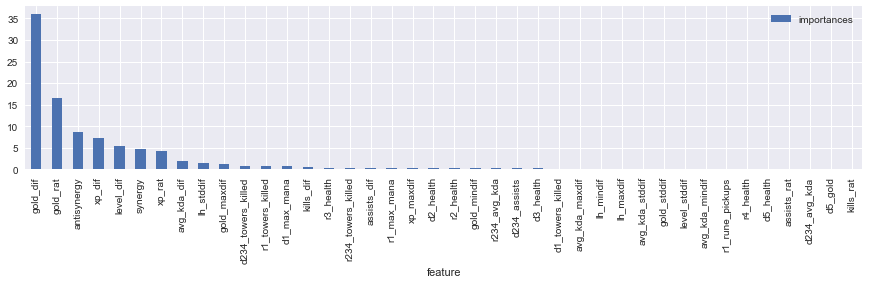

,importances
feature,
gold_dif,36.000549
gold_rat,16.497193
antisynergy,8.701751
xp_dif,7.314134
level_dif,5.489804


In [27]:
df_importances = pd.DataFrame(data = {'feature':train.columns,'importances':model_cb.feature_importances_})
df_importances.sort_values(by=['importances'],inplace=True,ascending=False)
df_importances = df_importances.set_index('feature')[:40]
df_importances.plot(kind='bar', figsize=(15, 3))
plt.show()
display(df_importances.head())

### Predict

In [28]:
y_test_pred = model_cb.predict_proba(test)[:, 1]
df_submission = pd.DataFrame({'radiant_win_prob': y_test_pred}, index=test_index)

In [29]:
import time
import os

current_timestamp = int(time.time())
submission_path = 'submissions/{}.csv'.format(current_timestamp)

if not os.path.exists('submissions'):
    os.makedirs('submissions')

print(submission_path)
df_submission.to_csv(submission_path, index=True)

submissions/1524319924.csv


In [6]:
fir = pd.read_csv("submissions/1524319924.csv").radiant_win_prob
sec = pd.read_csv("submissions/1524315756.csv").radiant_win_prob
thi = pd.read_csv("submissions/1524314431.csv").radiant_win_prob

In [12]:
commit = (fir+sec+thi)/3

In [15]:
df_submission = pd.DataFrame({'radiant_win_prob': commit}, index=test_index)

In [21]:
com = pd.read_csv("submissions/1524319924.csv")

In [23]:
com.radiant_win_prob = commit

In [28]:
import time
import os

current_timestamp = int(time.time())
submission_path = 'submissions/{}.csv'.format(current_timestamp)

if not os.path.exists('submissions'):
    os.makedirs('submissions')

print(submission_path)
com.to_csv(submission_path, index=True)

submissions/1524323639.csv


In [27]:
com

,match_id_hash,radiant_win_prob
0,30cc2d778dca82f2edb568ce9b585caa,0.407899
1,70e5ba30f367cea48793b9003fab9d38,0.980993
2,4d9ef74d3a2025d79e9423105fd73d41,0.971063
3,2bb79e0c1eaac1608e5a09c8e0c6a555,0.844358
4,bec17f099b01d67edc82dfb5ce735a43,0.222596
5,038acbb47d9eb54c11962d07cce8d829,0.104008
6,b891f03bb2a86d78b84043437fc95e04,0.944204
7,ff898afdb5bb5c7163bde45a009503f7,0.065335
8,72e6b1c31c718c0806f9aaeb8b7290a9,0.574180
9,abd97ab60ceca3ae6f00a28baea8a43c,0.565008
